# Experiment 2 Model Results

## Imports & Set Up

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# enough with the warnings!
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", module="statsmodels")

# PLOT STYLING
# Display plots in the notebook
%matplotlib inline 

#if you have jupyterthemes:
from jupyterthemes import jtplot
jtplot.style('grade3',context='paper', fscale=1.3)
jtplot.figsize(6, 6, 1.2)
# if you don't have jupyterthemes, but have seaborn you can use:
# sns.set(context='paper', rc={'figure.facecolor':'white'}, font_scale=1.7)

## Data Manipulation

In [2]:
def get_model_param(parameter,stats_csv):
    # Import and read data
    import pandas as pd
    import numpy as np
    df = pd.read_csv(stats_csv)
    
    # Clean up the DataFrame, and Add 'level' column
    df['param'] = df['Unnamed: 0']; # a more useful column name
    df = pd.DataFrame([df['param'], df['mean'], df['std']]) # only keep the bits we use
    df = df.T
    
    level = pd.Series(0, index=df.index)
    df['level'] = level # 0 ~ subject, 1 ~ group
    df.drop('level', axis=1)
    
    # Change the level for group parameters to 1 and remove group-level entries
    for i in range(len(df)):
        if '_' not in df.ix[i,'param'] or '.' not in df.ix[i,'param']:
            # All subject-level params have a '_' and '.' while group do not
            df.ix[i,'level'] = 1
    df = df[df['level'] == 1]
    mask = (df.param.str.startswith('%s'%parameter) & (df.param.str.find('_') == -1 ))
    df = df[mask]
    
    # Create arrays to hold subj_idx, parameter value, condition and mean parameter estimate
    rps = np.array([])
    rprobs = np.array([])

    # fill arrays of sids, params and conds
    for i in df.index:    
        cond = str(df.ix[i, 'param'].split('(')[1].split(')')[0]) # condition
        rp = cond.split('.')[0]
        rprob = cond.split('.')[3]
        
        # append to storage arrays
        rps = np.append(rps, rp)
        rprobs = np.append(rprobs, rprob)    
    
    # Create a new DataFrame from the arrays (converted to Series)
    rps = pd.Series(rps)
    rprobs = pd.Series(rprobs)

    new_df = pd.DataFrame([rps, rprobs, df['mean'].values, df['std'].values],
                          index =['rwd_pen', 'rprob', '%s_mean'%parameter, '%s_std'%parameter])
    new_df = new_df.T
    
    return new_df

In [3]:
drift_df = get_model_param('v', 'exp2model_stats.csv' )
drift_df

,rwd_pen,rprob,v_mean,v_std
0,1,15,-4.15382,0.615623
1,1,3,-3.10283,0.607645
2,1,7,-0.754798,0.601433
3,1,85,2.4735,0.604756
4,2,15,-3.86048,0.612129
5,2,3,-2.81827,0.595853
6,2,7,2.45451,0.609705
7,2,85,4.45811,0.613599


In [4]:
bias_df = get_model_param('z', 'exp2model_stats.csv')
bias_df

,rwd_pen,rprob,z_mean,z_std
0,1,15,0.544133,0.020602
1,1,3,0.503955,0.0209083
2,1,7,0.503092,0.0205602
3,1,85,0.436419,0.020489
4,2,15,0.569339,0.0206214
5,2,3,0.50345,0.0206787
6,2,7,0.48957,0.0210665
7,2,85,0.435573,0.0211703


In [5]:
# relabel some of the data for descriptive legend
for i in range(len(drift_df.rwd_pen)):
    if drift_df.loc[i,'rwd_pen'] == '1':
        drift_df.loc[i,'rwd_pen'] = 'reward = penalty'
    elif drift_df.loc[i,'rwd_pen'] == '2':
        drift_df.loc[i,'rwd_pen'] = 'reward = 2(penalty)'

## Drift Rate

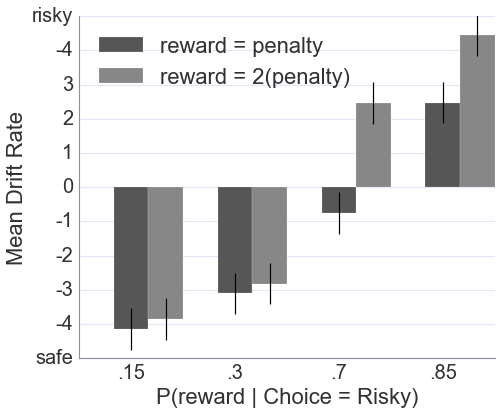

In [6]:
# code adapted from a stackoverflow answer to: https://stackoverflow.com/questions/42017049/seaborn-how-to-add-error-bars-on-a-grouped-barplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def grouped_barplot(df, cat,subcat, val , err):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    cdict = sns.color_palette('Greys_d',2)
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{}".format(gr), yerr=dfg[err].values,
                color=cdict[i],ecolor='black')
    plt.xlabel('P(reward | Choice = Risky)', fontsize=22)
    plt.ylabel('Mean Drift Rate', fontsize=22)
    plt.yticks(np.linspace(-5,5,11),['safe','-4','-3','-2','-1','0','1','2','3','-4','risky'], fontsize=20)
    plt.xticks(x,['.15','.3','.7','.85'], fontsize=20)
    plt.ylim([-5,5])
    plt.legend(loc='best',fontsize=22)
    sns.despine()
    plt.grid(axis='x')
    plt.savefig('exp2_drifts.eps')
    plt.savefig('exp2_drifts.svg')
    plt.show()


cat = "rprob"
subcat = "rwd_pen"
val = "v_mean"
err = "v_std"
grouped_barplot(drift_df, cat, subcat, val, err )

## Bias

In [7]:
bias_df

,rwd_pen,rprob,z_mean,z_std
0,1,15,0.544133,0.020602
1,1,3,0.503955,0.0209083
2,1,7,0.503092,0.0205602
3,1,85,0.436419,0.020489
4,2,15,0.569339,0.0206214
5,2,3,0.50345,0.0206787
6,2,7,0.48957,0.0210665
7,2,85,0.435573,0.0211703


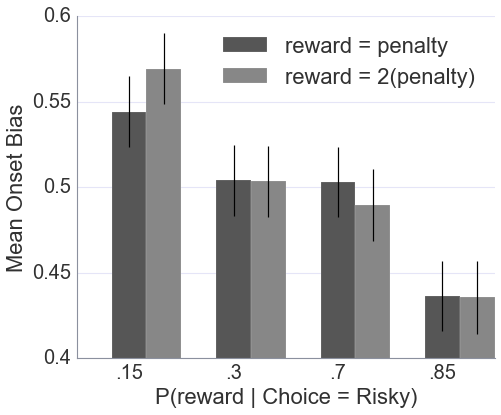

In [8]:
# code adapted from a stackoverflow answer to: https://stackoverflow.com/questions/42017049/seaborn-how-to-add-error-bars-on-a-grouped-barplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def grouped_barplot(df, cat,subcat, val , err):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    cdict = sns.color_palette('Greys_d',2)
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{}".format(gr), yerr=dfg[err].values,
                color=cdict[i],ecolor='black')
    plt.xlabel('P(reward | Choice = Risky)', fontsize=22)
    plt.ylabel('Mean Onset Bias', fontsize=22)
    plt.yticks(np.linspace(.4,.6,5),np.linspace(.4,.6,5), fontsize=20)
    plt.ylim([.4, .6])
    plt.xticks(x,['.15','.3','.7','.85'], fontsize=20)
    plt.legend(['reward = penalty','reward = 2(penalty)'],loc='best',fontsize=22)
    sns.despine()
    plt.grid(axis='x')
    plt.savefig('exp2_bias.eps')
    plt.savefig('exp2_bias.svg')
    plt.show()


cat = "rprob"
subcat = "rwd_pen"
val = "z_mean"
err = "z_std"
grouped_barplot(bias_df, cat, subcat, val, err )